In [7]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/")

# load input RNA allelic counts
input_files = [ "/gpfs/commons/home/mschertzer/asb_model/all-input-rep1_allelic.out", # this is bio rep 1 (two sequencing runs combined)
               "/gpfs/commons/home/mschertzer/pilot_pool/allelic/technical_rep1/input-rep2_allelic.out"] # bio rep 2, low sequencing depth

input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files ]

# observed genotype data (after running StrandScript)
geno = io_utils.loadGenotypes('/gpfs/commons/home/phalmos/genotypes/CIRMlines_flipped.vcf', 
                     maxlines = None, 
                     posterior = False).rename(columns = {"SNP" : "variantID"})

# Deconvolution

sum(w)=0.987529 ideally would be 1


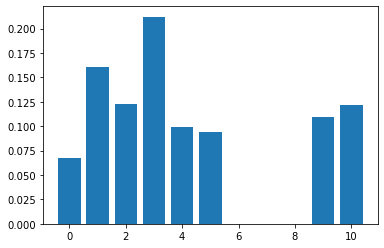

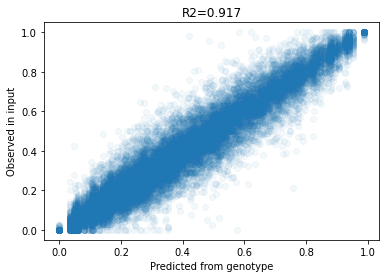

sum(w)=0.986087 ideally would be 1


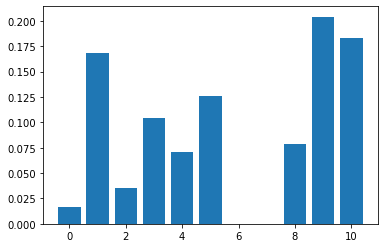

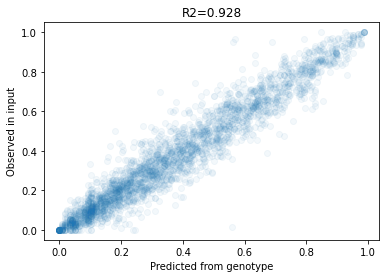

In [12]:
w = [ deconvolve.deconvolve(geno, inp) for inp in input_counts ]

In [14]:
props = pd.DataFrame(w).transpose()
props.columns = ["rep1","rep2"]
props["line"] = geno.columns[5:16]
props.iloc[:,[2,0,1]].to_csv(results_dir / "deconv.tsv", index = False, sep = "\t")

props

,rep1,rep2,line
0,0.067854,0.016107,CW30274-1-1194512543_CW30274-1-1194512543
1,0.160609,0.167875,CW30454-1-1194512472_CW30454-1-1194512472
2,0.123022,0.035715,CW30421-1-1194512512_CW30421-1-1194512512
3,0.212105,0.103827,CW70372-1-1194512488_CW70372-1-1194512488
4,0.098892,0.071163,CW40201-1-1194512480_CW40201-1-1194512480
5,0.093769,0.125951,CW30525-1-1194512464_CW30525-1-1194512464
6,0.000000,0.000000,CW30190-1-1194512504_CW30190-1-1194512504
7,0.000256,0.000000,CW30108-1-1194512496_CW30108-1-1194512496
8,0.000000,0.078558,CW30154-1-1194512551_CW30154-1-1194512551
9,0.109172,0.204062,CW70179-1-1194512535_CW70179-1-1194512535


# Load and check imputed genotypes

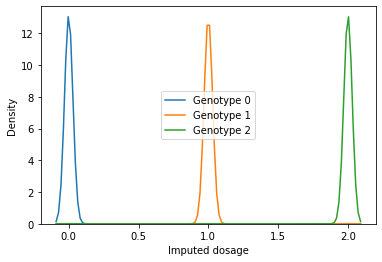

In [15]:
# load sanger (and cache) imputed data
sanger_feather = Path("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.feather")
if sanger_feather.is_file(): 
    sanger = pd.read_feather(sanger_feather)
    del sanger["index"]
else: # this is pretty slow to read, so cache to feather
    sanger = io_utils.loadGenotypes("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.vcf.gz", 
                           maxlines = None, 
                           posterior = True,
                           posterior_index = 2,
                          print_every = 10000) 
    sanger.reset_index().to_feather(sanger_feather)

cirm_lines = sanger.columns[5:16]
sanger_merge = geno.rename(columns = {"variantID" : "SNP"}).merge(sanger, on = ["SNP","refAllele","altAllele"], suffixes = ("_geno","_imp"))
geno_geno = sanger_merge.loc[:,cirm_lines.astype(str) + "_geno"].to_numpy()
geno_imp = sanger_merge.loc[:,cirm_lines.astype(str) + "_imp"].to_numpy()

### check imputation looks sensible on genotyped variants 
sns.kdeplot(geno_imp[geno_geno==0.], bw = 0.03, label = "Genotype 0")
sns.kdeplot(geno_imp[geno_geno==.5], bw = 0.03, label = "Genotype 1")
sns.kdeplot(geno_imp[geno_geno==1.], bw = 0.03, label = "Genotype 2")
plt.xlabel("Imputed dosage")
plt.ylabel("Density")
plt.legend()
plt.show() # nice! 

# Load IP count data and join with input and genotype

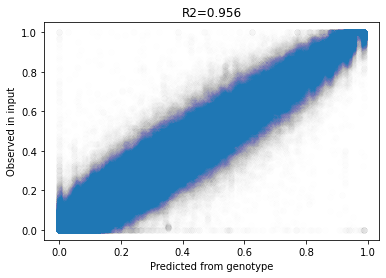

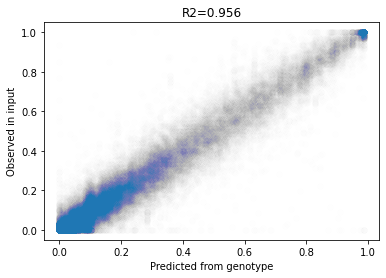

In [16]:
IP_files = [ "/gpfs/commons/home/mschertzer/asb_model/all_hnrnpk-rep1_allelic.out", 
             "/gpfs/commons/home/mschertzer/pilot_pool/allelic/technical_rep1/hnrnpk-rep2_allelic.out" ]
IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files ]

merged,dat_sub = deconvolve.merge_geno_and_counts(sanger, input_counts[0], IP_counts[0], w[0], plot = True)
merged_2,dat_sub_2 = deconvolve.merge_geno_and_counts(sanger, input_counts[1], IP_counts[1], w[1], plot = True,
        input_total_min = 10, allele_count_min = 2, ip_total_min = 10) # more lenient thresholds for lower seq depth

dat_sub["input_ratio"] = dat_sub.altCount_input / dat_sub.totalCount_input
dat_sub["IP_ratio"] = dat_sub.altCount_IP / dat_sub.totalCount_IP

# Run beta models

This can't handle replicates. 

Mean field guide
{'input_conc': 118.38629150390625, 'input_count_conc': 153.99916076660156, 'IP_conc': 46.37624740600586, 'IP_count_conc': 577.3382568359375}


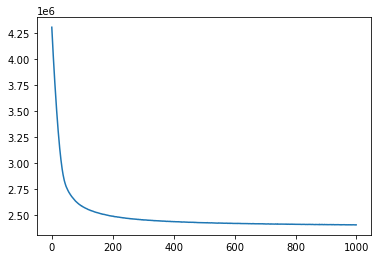

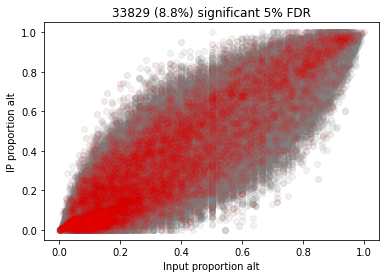

         position_x contig    variantID refAllele altAllele contig_y  \
932484      8946486  chr16   rs28440030         G         A    chr16   
2930903    13434581   chr6    rs9349618         T         G     chr6   
2930308    13294976   chr6      rs20500         G         A     chr6   
2001735    69311210   chr2    rs4854542         T         C     chr2   
2212369     6553664   chr3   rs75284943         G         A     chr3   
2212370     6554226   chr3   rs17045232         C         G     chr3   
3165092    21927898   chr7  rs117819282         T         A     chr7   
2212396     6562363   chr3   rs77035004         C         T     chr3   
1301682    13037734  chr19   rs62109865         G         A    chr19   
1500935    64547908   chr1    rs6677653         T         C     chr1   
5761        3165808  chr10    rs9423471         G         A    chr10   
437084     57064399  chr12   rs17444799         C         T    chr12   
2212507     6593181   chr3   rs73018992         G         A     

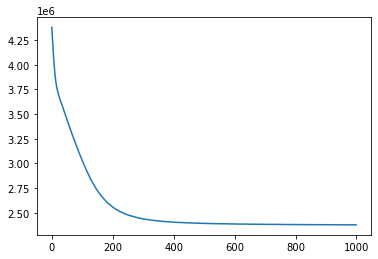

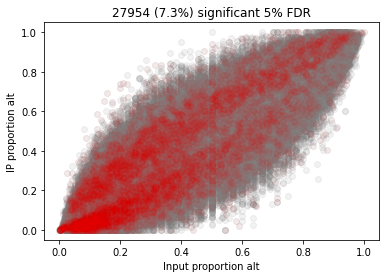

         position_x contig    variantID refAllele altAllele contig_y  \
155781    124166810  chr10  rs117802070         C         T    chr10   
2594602    88860764   chr4   rs17013569         G         A     chr4   
2594601    88860740   chr4   rs17013566         C         T     chr4   
1811387    38962781  chr21  rs113880582         C         T    chr21   
2594592    88859319   chr4   rs72870126         A         G     chr4   
2594591    88859185   chr4   rs76387095         T         A     chr4   
1811386    38962517  chr21    rs4634000         C         T    chr21   
380895     12714372  chr12   rs11054972         T         C    chr12   
1811375    38960168  chr21    rs9984798         G         A    chr21   
3677170   130831329   chr9   rs10739706         G         A     chr9   
2455069   176022346   chr3     rs953067         A         G     chr3   
764776    101537913  chr14    rs3742407         C         T    chr14   
2594565    88855003   chr4    rs9968306         G         T     

In [21]:
device = "cpu"
data = asb_data.RelativeASBdata.from_pandas(dat_sub, device = device)

for use_structured_guide in (False,True):

    print("Structured guide" if use_structured_guide else "Mean field guide")
    
    losses, model, guide, stats, samples = beta_model.fit(data, use_structured_guide = use_structured_guide)

    plt.plot(losses)
    plt.show()
    losses[-1] # 133094 compared to 117421 for structured SVI (so guess latter is better)

    p = (samples["input_ratio"] > samples["IP_ratio"]).float().mean(0).squeeze().numpy()

    # proportion significant
    dat_sub["q"] = np.minimum(p,1.-p)
    
    effect_size = torch.logit(samples["IP_ratio"]) - torch.logit(samples["input_ratio"])
    dat_sub["effect_mean"] = effect_size.mean(0).squeeze().numpy()
    dat_sub["effect_std"] = effect_size.std(0).squeeze().numpy()

    dat_sub.drop(columns = ["input_ratio", "IP_ratio"]
                ).to_csv(results_dir / ("beta" + ("_struct" if use_structured_guide else "") + "_results.tsv.gz"), 
                         index = False, sep = "\t")

    plt.scatter(dat_sub.input_ratio, dat_sub.IP_ratio,alpha=0.1, color="gray")
    dat_ss = dat_sub[dat_sub.q < fdr_threshold]
    plt.scatter(dat_ss.input_ratio, dat_ss.IP_ratio,alpha=0.03, color = "red")
    plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
    plt.title('%i (%.1f%%) significant %.0f%% FDR' % ((dat_sub["q"] < 0.1).sum(), 100. * (dat_sub["q"] < 0.1).mean(), fdr_threshold*100))
    plt.show()
    
    print(dat_sub.sort_values("q").head(20))


# Normal model without replicates

Could also run this with the mean field guide. 

{'ase_scale': 0.21769580245018005, 'input_count_conc': 406.26348876953125, 'asb_scale': 0.24362678825855255, 'IP_count_conc': 339.67828369140625, 'ase_t_df': 4.6940226554870605, 'asb_t_df': 32.441673278808594}


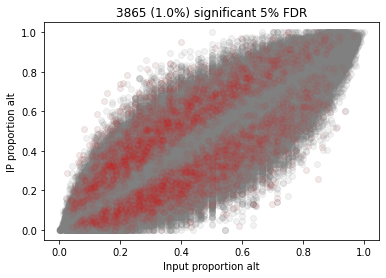

,position_x,contig,variantID,refAllele,altAllele,contig_y,position,refCount_input,altCount_input,totalCount_input,allelic_ratio,pred_ratio,refCount_IP,altCount_IP,totalCount_IP,input_ratio,IP_ratio,q,effect_mean,effect_std
3253531,93300636,chr7,rs6970823,G,A,chr7,93671324,25,38,63,0.603175,0.387292,26,66,92,0.603175,0.717391,0.0,0.431576,0.152738
3502591,132328082,chr8,rs72718407,C,T,chr8,131315835,368,69,437,0.157895,0.424997,329,750,1079,0.157895,0.695088,0.0,1.807341,0.212411
3292562,125578271,chr7,rs35276989,A,C,chr7,125938217,159,371,530,0.700000,0.470766,367,1069,1436,0.700000,0.744429,0.0,0.335786,0.113243
2962014,35863886,chr6,rs9470162,C,T,chr6,35896109,79,29,108,0.268519,0.358874,122,98,220,0.268519,0.445455,0.0,0.342885,0.127830
532809,132323706,chr12,rs61943911,A,T,chr12,131839161,99,5,104,0.048077,0.044069,245,36,281,0.048077,0.128114,0.0,0.511322,0.173181
1407790,11801642,chr1,rs4073489,G,A,chr1,11741585,43,23,66,0.348485,0.375027,206,209,415,0.348485,0.503614,0.0,0.335246,0.094755
1822737,45182001,chr21,rs1300,T,C,chr21,43762120,128,147,275,0.534545,0.539256,28,63,91,0.534545,0.692308,0.0,0.368849,0.156901
3325821,149186767,chr7,rs4727074,T,A,chr7,149489676,8,14,22,0.636364,0.666303,20,106,126,0.636364,0.841270,0.0,0.476055,0.177638
3471220,104570898,chr8,rs2449910,A,G,chr8,103558670,73,50,123,0.406504,0.337357,57,11,68,0.406504,0.161765,0.0,-0.496163,0.210443
2827081,118845139,chr5,rs32664,G,A,chr5,119509444,29,40,69,0.579710,0.540777,76,40,116,0.579710,0.344828,0.0,-0.523805,0.191876


In [24]:
losses, model, guide, stats, samples = gaussian_model.fit(data, use_structured_guide = True)

{ k:v["mean"].item() for k,v in stats.items() if v["mean"].numel() ==1 }

p = (samples['asb'] > 0.).float().mean(0).squeeze().numpy()

dat_sub["q"] = np.minimum(p,1.-p)
dat_sub["effect_mean"] = samples["asb"].mean(0).squeeze().numpy()
dat_sub["effect_std"] = samples["asb"].std(0).squeeze().numpy()

fdr_threshold = 0.05
plt.scatter(dat_sub.input_ratio, dat_sub.IP_ratio,alpha=0.1, color="gray")
dat_ss = dat_sub[dat_sub.q < fdr_threshold]
plt.scatter(dat_ss.input_ratio, dat_ss.IP_ratio,alpha=0.03, color = "red")
plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
plt.title('%i (%.1f%%) significant %.0f%% FDR' % ((dat_sub["q"] < fdr_threshold).sum(), 100. * (dat_sub["q"] < fdr_threshold).mean(), 100 * fdr_threshold))
plt.show()

dat_sub.drop(columns = ["input_ratio", "IP_ratio"]).to_csv(results_dir / "normal_struct_results.tsv.gz", index = False, sep = "\t")

dat_sub.sort_values("q").head(20)

# Replicates model

In [25]:
#both = pd.concat( [dat_sub.merge( dat_sub_2.loc[:,["variantID"]], on = "variantID"), # only shared SNPs
#                dat_sub_2.merge( dat_sub.loc[:,["variantID"]], on = "variantID")], axis = 0)
both = pd.concat( (dat_sub, dat_sub_2), axis = 0)

data_both = asb_data.ReplicateASBdata.from_pandas(both)

losses, model, guide, stats, samples = gaussian_model.fit(data_both, use_structured_guide = True)

both["IP_ratio"] = both.altCount_IP / both.totalCount_IP

asb_loc = pyro.param("asb_loc").detach().numpy() # ~= samples["asb"].mean(0).squeeze().numpy()
asb_sd = torch.sqrt(pyro.param("asb_scale_param")**2 + pyro.param("asb_corr")**2).detach().numpy() # ~= samples["asb"].std(0).squeeze().numpy()

both["effect_mean"] = asb_loc[data_both.snp_indices]
both["effect_std"] = asb_sd[data_both.snp_indices]

q = scipy.stats.norm().cdf(-np.abs(asb_loc / asb_sd))
both["q"] = q[data_both.snp_indices]
both.sort_values("q").head(20)

both.drop(columns = ["input_ratio", "IP_ratio"]).to_csv(results_dir / "rep_struct_results.tsv.gz", index = False, sep = "\t")

both.sort_values("q").head(20)

{'ase_scale': 0.21537457406520844, 'input_count_conc': 367.4052429199219, 'asb_scale': 0.240028515458107, 'IP_count_conc': 315.21539306640625, 'ase_t_df': 4.62415885925293, 'asb_t_df': 31.042034149169922}


,position_x,contig,variantID,refAllele,altAllele,contig_y,position,refCount_input,altCount_input,totalCount_input,allelic_ratio,pred_ratio,refCount_IP,altCount_IP,totalCount_IP,input_ratio,IP_ratio,q,effect_mean,effect_std
1605201,132328082,chr8,rs72718407,C,T,chr8,131315835,57,5,62,0.080645,0.300230,74,53,127,NaN,0.417323,1.211352e-23,1.744499,0.175256
3502591,132328082,chr8,rs72718407,C,T,chr8,131315835,368,69,437,0.157895,0.424997,329,750,1079,0.157895,0.695088,1.211352e-23,1.744499,0.175256
591929,8387207,chr19,rs1057232,G,A,chr19,8322323,702,20,722,0.027701,0.738403,60,18,78,NaN,0.230769,4.130213e-19,1.907647,0.215396
1290505,8387207,chr19,rs1057232,G,A,chr19,8322323,4170,104,4274,0.024333,0.715334,294,118,412,0.024333,0.286408,4.130213e-19,1.907647,0.215396
1192211,88853670,chr4,rs12504187,T,C,chr4,87932518,54,33,87,0.379310,0.842984,9,39,48,NaN,0.812500,3.929420e-18,1.673940,0.194607
2594552,88853670,chr4,rs12504187,T,C,chr4,87932518,330,133,463,0.287257,0.809304,53,234,287,0.287257,0.815331,3.929420e-18,1.673940,0.194607
3086177,149182253,chr6,rs113200035,G,T,chr6,148861117,99,131,230,0.569565,0.148058,17,207,224,0.569565,0.924107,5.336891e-16,1.497935,0.186802
1414933,149182253,chr6,rs113200035,G,T,chr6,148861117,24,15,39,0.384615,0.204115,2,17,19,NaN,0.894737,5.336891e-16,1.497935,0.186802
1192224,88855003,chr4,rs9968306,G,T,chr4,87933851,46,82,128,0.640625,0.842984,13,130,143,NaN,0.909091,1.137863e-08,1.391655,0.248971
2594565,88855003,chr4,rs9968306,G,T,chr4,87933851,347,450,797,0.564617,0.809304,97,820,917,0.564617,0.894220,1.137863e-08,1.391655,0.248971


Plotting is a bit more complicated because we have two reps. So just look at counts for rep 1. 

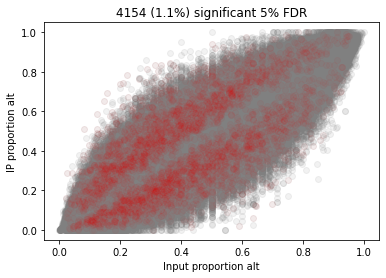

In [26]:
snp_lookup = both.loc[:,["contig","position","position_x","variantID"]].drop_duplicates().rename(columns = {"position_x" : "position_hg19"})
res = pd.DataFrame( {"variantID" : data_both.snps, "q" : q, "asb_mean" : asb_loc, "asb_sd" : asb_sd })
res = snp_lookup.merge( res, on = "variantID" )
res.to_csv(results_dir / "rep_struct_asb.tsv.gz", index = False, sep = "\t")

to_plot = res.loc[:,["variantID","q"]].merge(dat_sub.loc[:,["variantID","input_ratio","totalCount_input","IP_ratio","totalCount_IP",]], on = "variantID")

plt.scatter(to_plot.input_ratio, to_plot.IP_ratio,alpha=0.1, color="gray")
dat_ss = to_plot[to_plot.q < fdr_threshold]
plt.scatter(dat_ss.input_ratio, dat_ss.IP_ratio,alpha=0.03, color = "red")
plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
plt.title('%i (%.1f%%) significant %.0f%% FDR' % ((res["q"] < fdr_threshold).sum(), 100. * (res["q"] < fdr_threshold).mean(), 100 * fdr_threshold))
plt.show()

<AxesSubplot:xlabel='totalCount_input_bin', ylabel='totalCount_IP_bin'>

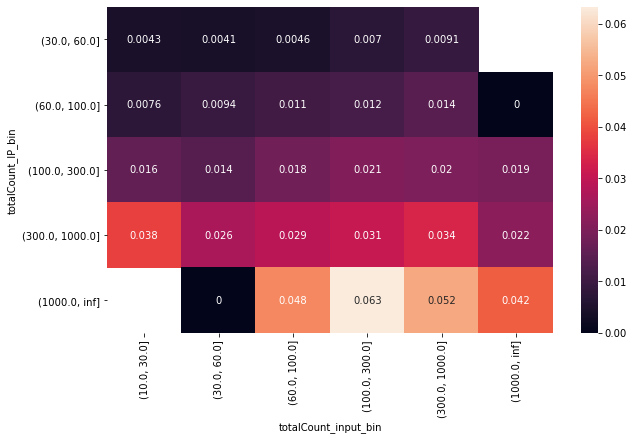

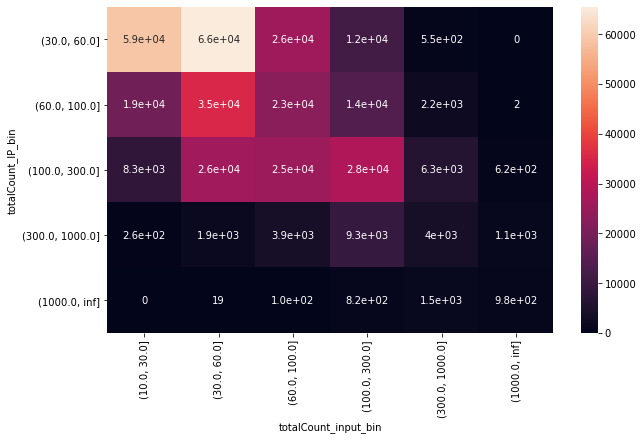

In [27]:
to_plot["totalCount_IP_bin"] = pd.cut(to_plot.totalCount_IP, [30,60,100,300,1000,np.inf], precision = -1)
to_plot["totalCount_input_bin"] = pd.cut(to_plot.totalCount_input, [9,30,60,100,300,1000,np.inf], precision = -1)
to_plot["asb"] = to_plot.q < fdr_threshold
to_plot["one"] = 1.
agg = to_plot.groupby(["totalCount_IP_bin","totalCount_input_bin"]).agg({"asb" : "mean", "one" : "sum"}).reset_index()
df_wide = agg.pivot_table( index='totalCount_IP_bin', columns='totalCount_input_bin', values='asb')
plt.figure(figsize=(10,6))
sns.heatmap(df_wide, annot = True)

df_wide = agg.pivot_table( index='totalCount_IP_bin', columns='totalCount_input_bin', values='one')
plt.figure(figsize=(10,6))
sns.heatmap(df_wide, annot = True)

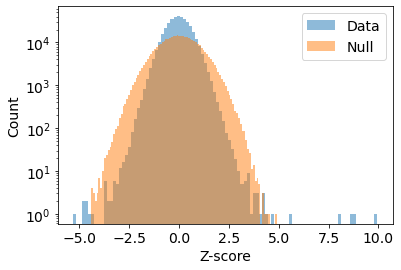

In [28]:
z = asb_loc / asb_sd
nu = np.random.normal(size=len(z))

plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(6, 4))
plt.hist(z,log=True, bins=100, alpha=0.5, label = "Data")
plt.hist(nu,log=True, bins=100, alpha = 0.5, label = "Null")
plt.legend()
plt.xlabel("Z-score")
plt.ylabel("Count")
plt.savefig("asb.pdf")
plt.show()